# Exploratory dataset analysis for polish hate-speech dataset

In [88]:
import os
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import TweetTokenizer, sent_tokenize
import nltk
from tqdm.notebook import tqdm
import itertools
import spacy
import collections
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import re
train_path = "../data/train"
test_path = "../data/test"

In [89]:
# run this instruction when running nltk for the first time
! python -m spacy download pl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 15.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [3]:
# TODO
# PROCESSING
# Check if html is in data
# Unicode normalisation
# Sentence segmentation and word tokenization.
# Stop word removal, stemming, lemmatization, removing digits/punctuation,
# lowercasing
# POS tagging, parsing
# NLTK tweet tokenizer
# handling emojis?
# remove urls?
# nltk remove - stopwords, digits, punctuation, lowercase
# stemming words PorterStemmer
# text normalisation
# FEATURE ENGINEERING
# named entity recognition ??? for augmentationprint(line)
# understnd the syntactic structure of the sentence


## Reading the data

In [4]:
with open(os.path.join(train_path, "training_set_clean_only_text.txt"), 'r') as file:
    lines = list(map(lambda line: line.rstrip("\n"), file.readlines()))

with open(os.path.join(train_path, "training_set_clean_only_tags.txt"), 'r') as file:
    classes = list(map(lambda line: int(line.rstrip("\n")), file.readlines()))

## Class distribution

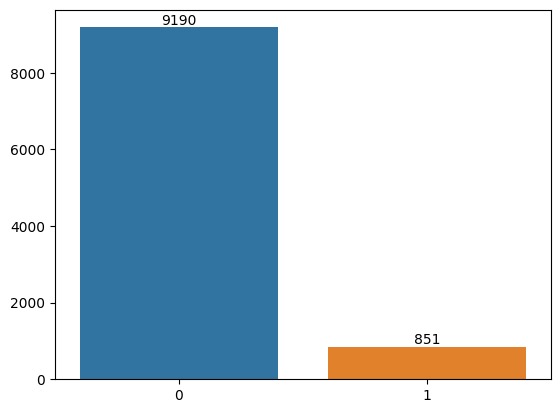

In [5]:
counted_classes = dict(Counter(classes))
ax = sns.barplot(x=list(counted_classes.keys()),y=list(counted_classes.values()))
for index, value in enumerate(counted_classes.values()):
    ax.text(index, value + 1, str(value), ha='center', va='bottom')

The dataset seems to be fairly unbalanced towards 0, some downsampling might be necessary.

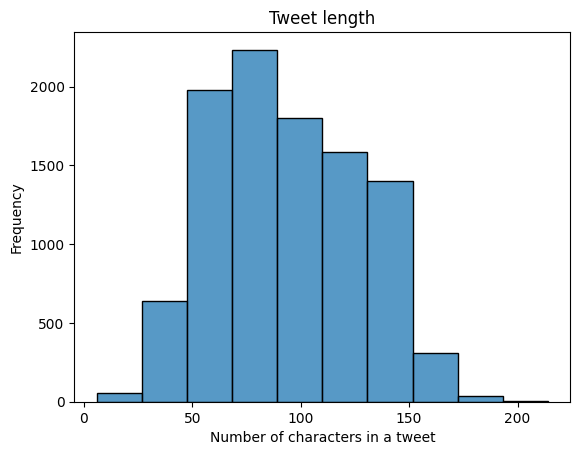

In [6]:
sns.histplot(list(map(len, lines)), kde=False, bins=10)
plt.xlabel('Number of characters in a tweet')
plt.ylabel('Frequency')
plt.title('Tweet length')
plt.show()


The tweet length seems to follow normal distribution with mean around 100 characters. It seems to correlate with real-life restriction on tweets that cant be longer than 280 characters.

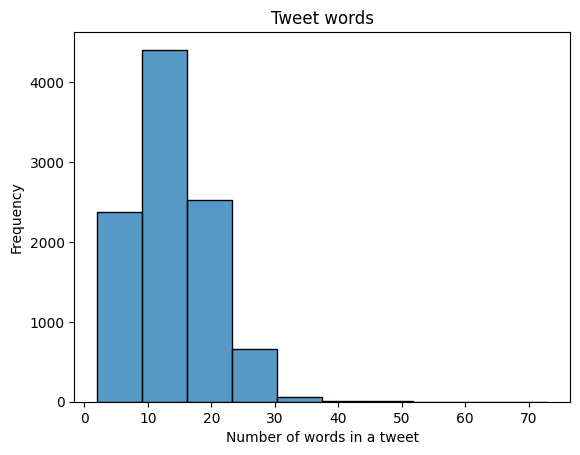

In [91]:
tw = TweetTokenizer()
tokenized_tweets = list(map(tw.tokenize, lines))

sns.histplot(list(map(len, tokenized_tweets)), kde=False, bins=10)
plt.xlabel('Number of words in a tweet')
plt.ylabel('Frequency')
plt.title('Tweet words')
plt.show()


Generally tweets have from 3 to 30 words with some outliers containing 40-50.

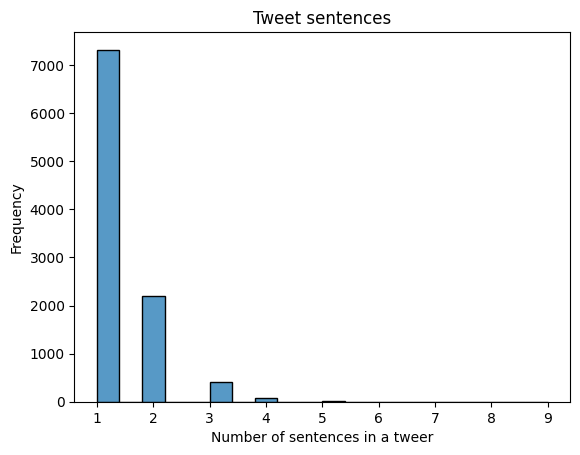

In [9]:
sentenized_tweets = list(map(sent_tokenize, lines))

sns.histplot(list(map(len, sentenized_tweets)), kde=False, bins=20)
plt.xlabel('Number of sentences in a tweer')
plt.ylabel('Frequency')
plt.title('Tweet sentences')
plt.show()


Most of the tweets have a single sentence with the number of tweets with more sentences sharply decreasing.

In [10]:
nlp = spacy.load('pl_core_news_sm')

ent_lines = list(tqdm(map(nlp, lines), total=len(lines)))
entities = list(map(lambda doc: list(map(lambda ent: (ent.text, ent.label_), doc.ents)), ent_lines))
entities = list(filter(lambda e: e, entities))
entities = list(itertools.chain(*entities))

  0%|          | 0/10041 [00:00<?, ?it/s]

## most common entity types

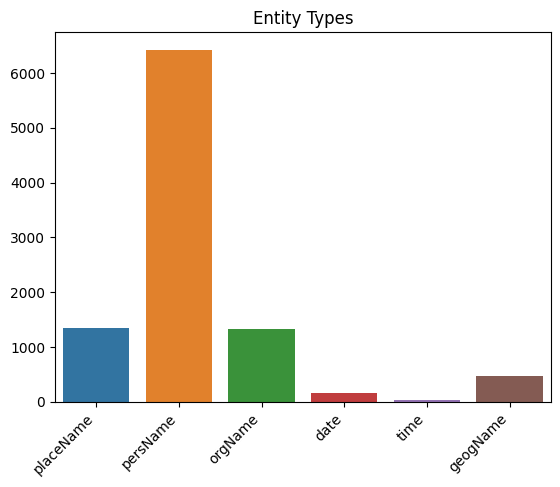

In [11]:
countd_entity_types = dict(collections.Counter(list(map(lambda x: x[1], entities))))
ax = sns.barplot(x=list(countd_entity_types.keys()),y=list(countd_entity_types.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Entity Types')
plt.show()

Most common named entitities represent person names. There are also fairly common ones representing place, organisation or geographical names. There are also few with dates or times.

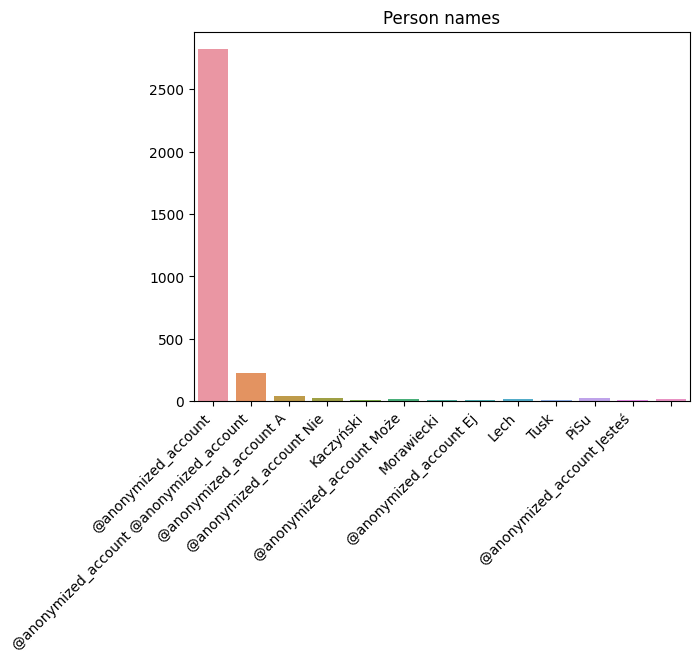

In [12]:
persName_ents = list(filter(lambda x: x[1] == 'persName', entities))
counted_persName_ents = dict(collections.Counter(list(map(lambda e: e[0], persName_ents))))
counted_persName_ents = {k: v for k, v in counted_persName_ents.items() if v > 10}
ax = sns.barplot(x=list(counted_persName_ents.keys()),y=list(counted_persName_ents.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Person names')
plt.show()

When it comes to named entities representing named entities, @anonymized_account is the most common. It shows that most tweets contained the response to certain person, but due to data protection it has been anonymized. There are also some mentions of political organisations or public personalities (politicians). The best strategy would be to replace all of them with a single named_entitiy value - PERSON.

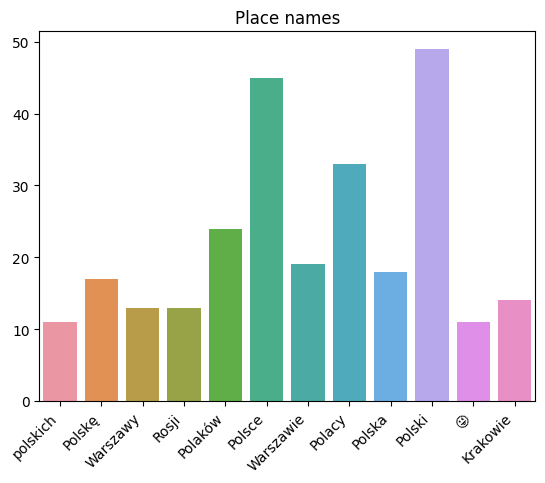

In [92]:
placeName_ents = list(filter(lambda x: x[1] == 'placeName', entities))
counted_placeName_ents = dict(collections.Counter(list(map(lambda e: e[0], placeName_ents))))
counted_placeName_ents = {k: v for k, v in counted_placeName_ents.items() if v > 10}
ax = sns.barplot(x=list(counted_placeName_ents.keys()),y=list(counted_placeName_ents.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Place names')
plt.show()

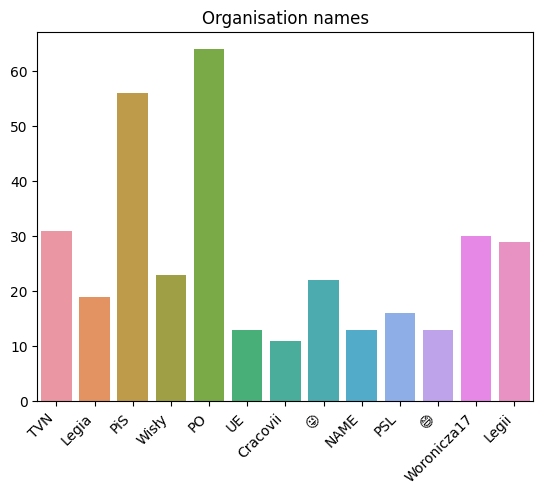

In [14]:
orgName_ents = list(filter(lambda x: x[1] == 'orgName', entities))
counted_orgName_ents = dict(collections.Counter(list(map(lambda e: e[0], orgName_ents))))
counted_orgName_ents = {k: v for k, v in counted_orgName_ents.items() if v > 10}
ax = sns.barplot(x=list(counted_orgName_ents.keys()),y=list(counted_orgName_ents.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Organisation names')
plt.show()

The most common organisation names represent tv stations, football clubs and and political parties. It seems to make sense to replace them with a single value - ORGANISATION.

/home/agorski/.cache/pypoetry/virtualenvs/src-aqY2EU_W-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


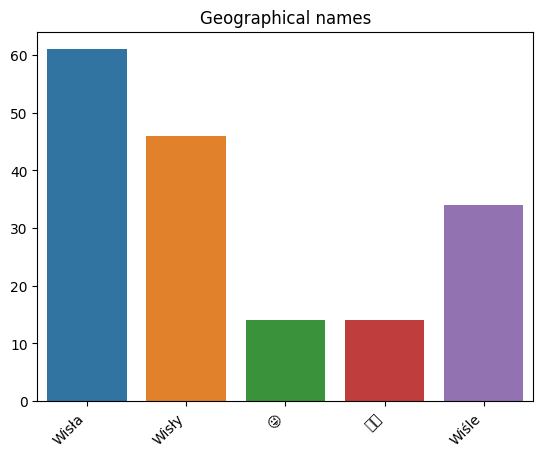

In [15]:
geogName_ents = list(filter(lambda x: x[1] == 'geogName', entities))
counted_geogName_ents = dict(collections.Counter(list(map(lambda e: e[0], geogName_ents))))
counted_geogName_ents = {k: v for k, v in counted_geogName_ents.items() if v > 10}
ax = sns.barplot(x=list(counted_geogName_ents.keys()),y=list(counted_geogName_ents.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Geographical names')
plt.show()

The geographical names probably relate to the name of the footbal club, not the river - It would be more reliable to first stem them, then run the named entitiy detection. Finally we could replace remaining geographical names with GEOGRAPHY.

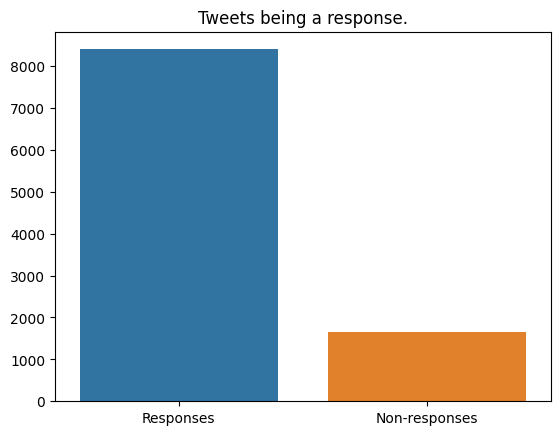

In [16]:
responses = {"Responses": len(list(filter(lambda tweet: "@anonymized_account" in tweet, lines))),
             "Non-responses": len(list(filter(lambda tweet: "@anonymized_account" not in tweet, lines)))
             }

ax = sns.barplot(x=list(responses.keys()), y=list(responses.values()))
ax.set_title('Tweets being a response.')
plt.show()


The vast majority are responses to tweets of other users so removing "anonymized_account" would lead to loss of information. It would make more sense to replace it with PERSON as mentioned above.

In [93]:
# checking if data contains html
def contains_html_using_regex(text):
    html_pattern = re.compile(r'<.*?>')  # Regular expression to match HTML tags
    return bool(html_pattern.search(text))


print(len(list(filter(contains_html_using_regex, lines))))

0


None of the tweets in the training dataset seems to contain html tags, so removing them does not seem to be needed.

In [94]:
ner_set = set([e[0] for e in entities])
docs = list(tqdm(map(nlp, lines), total=len(lines)))

  0%|          | 0/10041 [00:00<?, ?it/s]

In [95]:
tw = TweetTokenizer()
words = [[token.text for token in doc if (not token.is_stop) and (not token.is_punct) and (not token.is_space) and (not token.ent_type)] for doc in docs]
tokenized_words = [list(filter(lambda word: 'anonymized' not in word, tokens)) for tokens in words]
tokenized_words = [" ".join(line) for line in words]
tokenized_words = list(map(tw.tokenize, tokenized_words))
tokenized_words = [list(filter(lambda word: 'http' not in word, w)) for w in tokenized_words]
words = list(itertools.chain(*tokenized_words))
words = list(filter(lambda word: 'anonymized_account' not in word, words))

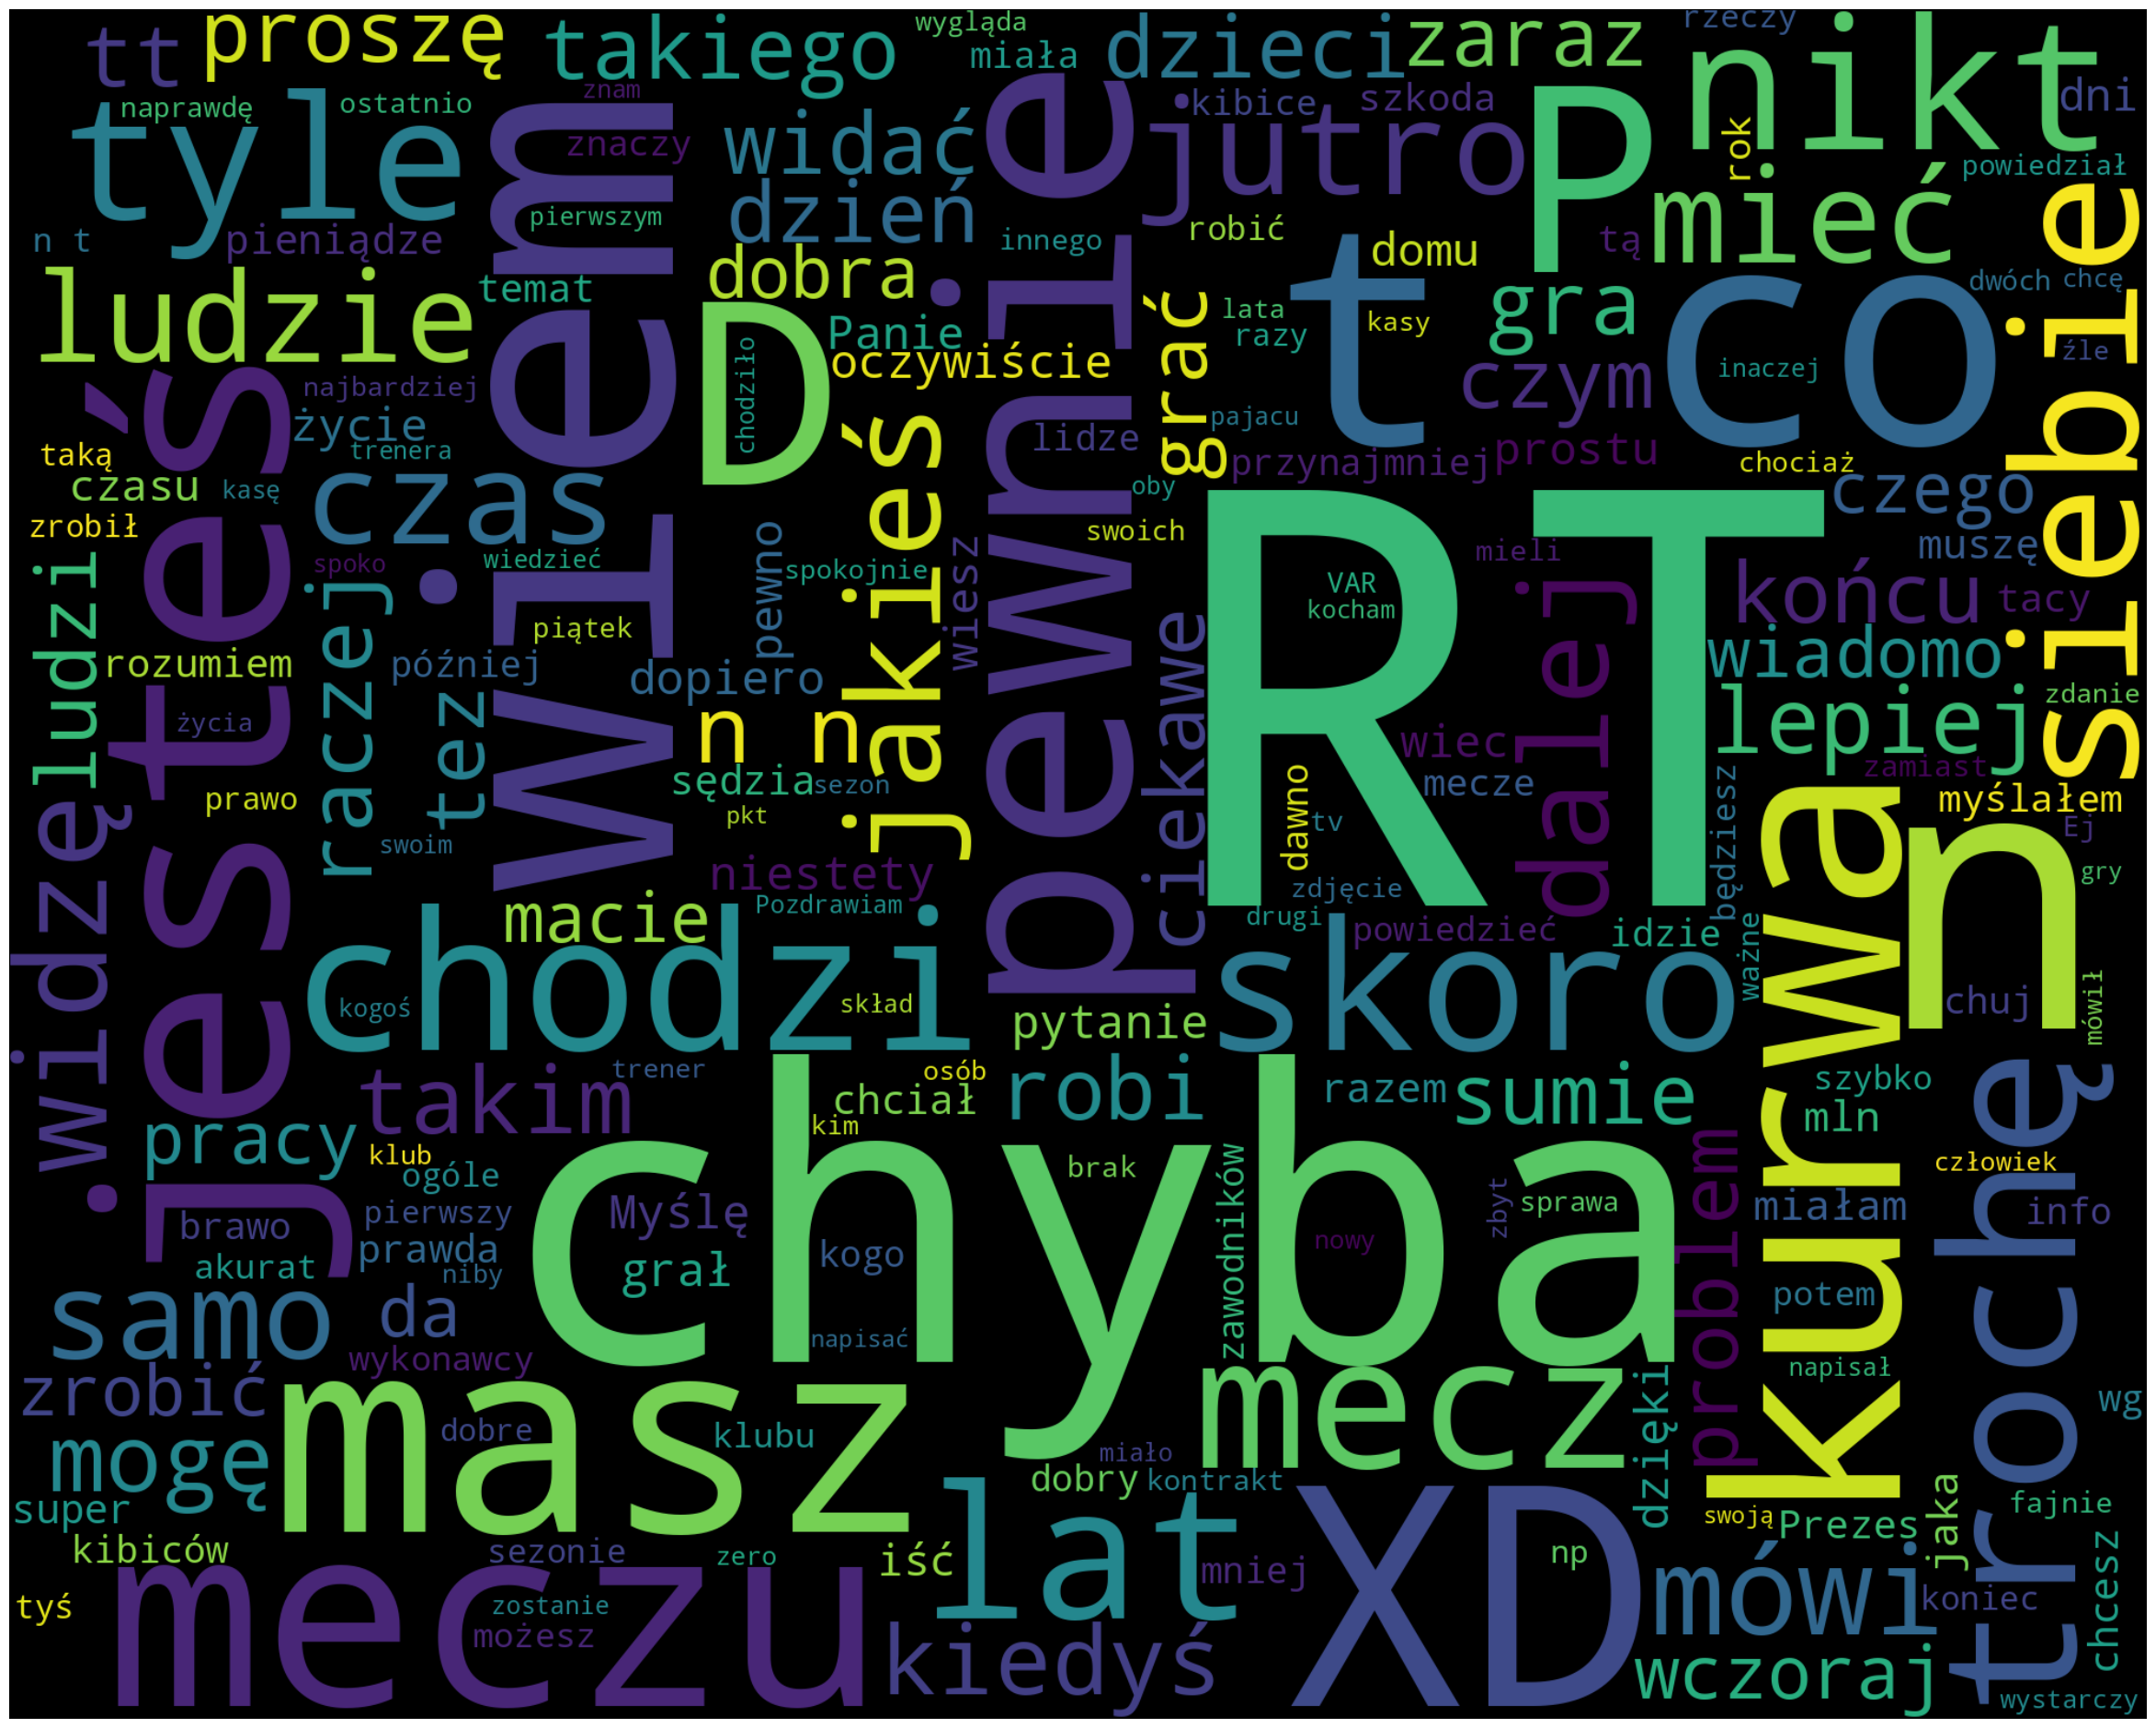

In [96]:
wordcloud = WordCloud(width=2000, height=1600).generate(" ".join(words))
fig, ax = plt.subplots(figsize=(30, 25))
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


The most common words in the wordcloud relate to football matches as the dataset is about tweets of the football club fans. They also experess doubt or laughter.

In [103]:
def get_top_ngram(corpus, n=2):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]

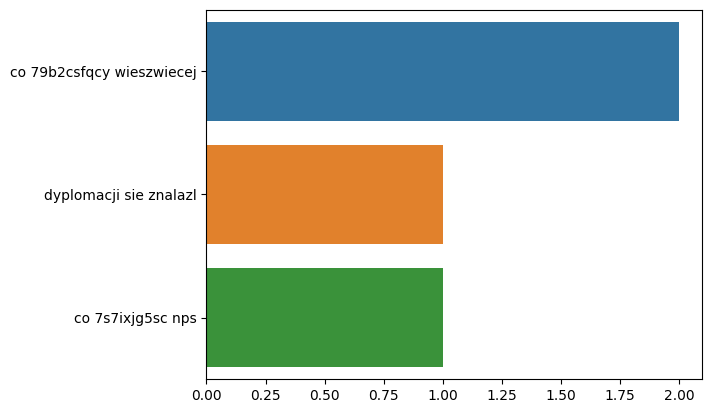

In [104]:
top_ngrams = get_top_ngram(corpus=words, n=3)
x,y=map(list,zip(*top_ngrams)) 
sns.barplot(x=y,y=x)
plt.show()

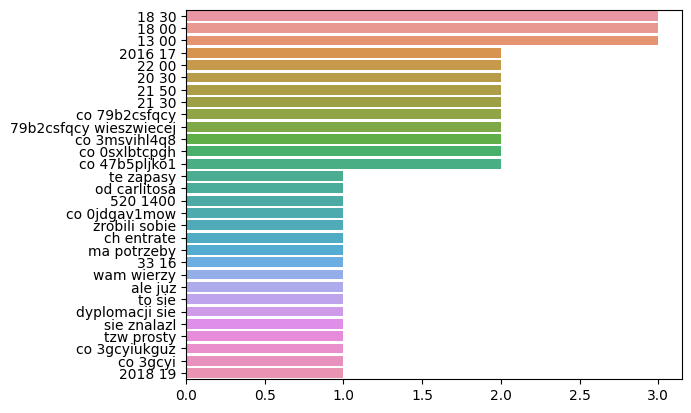

In [105]:
top_ngrams = get_top_ngram(corpus=words, n=2)
x,y=map(list,zip(*top_ngrams)) 
sns.barplot(x=y,y=x)
plt.show()

The most common bigrams relate either to response to a tweet or the time of the match.